#### Ripser Time Series Data
- Last Modified: 28 November, 2018
- Authors: Zachary Neronha and Dhananjay Bhaskar

In [64]:
library(R.matlab)
library(TDA)
library(repr)
library(stringr)
library(ripserr)
library(ggplot2)
library(pracma)
library(RColorBrewer)
library(fields)
library(lattice)

library(grid)
library(latex2exp)
library(graphics)

In [2]:
## Parse raw output from Ripser
parseOutput = function( output ){
    
    ## Number of intervals by dimension
    indices            = grep( "persistence intervals in dim " , output , value = FALSE )
    maxDimension       = length( indices ) - 1
    indices            = c( indices , length( output ) )
    
    ## Convert output in matrix
    diagram = matrix(, ncol = 3, nrow = 0 )
    
    ## Loop each group of intervals by dimension
    for( dim in 0:maxDimension ){
        
        ## Select intervals
        if( dim == maxDimension ){
            intervals = output[ ( indices[ dim + 1 ] + 1):( indices[ dim + 2 ] ) ]
        }else{
            intervals = output[ ( indices[ dim + 1 ] + 1):( indices[ dim + 2 ] - 1 ) ]
        }
        
        ## Removed lines from output
        intervals = grep( "\\[\\d*\\.?\\d+\\,\\d*\\.?\\d+\\)" , intervals , value = TRUE )
        
        ## Remove punctuation from intervals
        intervals = gsub( "(\\s|\\[|\\))" , "" , intervals )
        
        ## Split interval and convert to numeric
        intervals = as.numeric( unlist( strsplit( intervals , "," ) ) )
        
        ## Convert ouput in matrix
        intervals = matrix( intervals , ncol = 2 , byrow = T )
        
        ## Add dimension column
        intervals = cbind( rep( dim , nrow( intervals ) ) , intervals )
        
        ## Add intervals to diagram
        diagram = rbind( diagram, intervals )
        
    }
    
    ## Format matrix to diagram format
    colnames( diagram ) = c( "dimension" , "Birth" , "Death" )
    
    return( diagram )    
}

## Calculate rips diagram using Ripser library
ripserDiag = function( X, dimension, threshold, format = "point-cloud" ){
    
    # Ripser likes to read files in, so use a temporary file
    f = tempfile()
    write.table(X, f, col.names = FALSE, row.names = FALSE)
    
    ## Set parameters as text
    dimension = as.character( dimension )
    threshold = as.character( threshold )
    
    ## Run Ripser using system command
    ripserOut = system2("/home/labmember/ripser/ripser", args = c("--dim", dimension, "--threshold", threshold, "--format", format , f), stdout = TRUE)
    
    return( parseOutput( ripserOut ) )
}

In [3]:
combinedbarcode = function(dim0intervals, dim1intervals, max_x_lim){
    
    numintervals_b0 = dim(dim0intervals)[1]
    numintervals_b1 = dim(dim1intervals)[1]
    
    ymat = linspace(0, 1, n = (numintervals_b0 + numintervals_b1 + 1))
    
    y_end = ymat[length(ymat)]
    ymat1 = ymat[1:numintervals_b1]
    ymat0 = ymat[(numintervals_b1+1):(length(ymat)-1)]
    
    g = ggplot()
    
    if (numintervals_b1 > 0){
        b1mat = dim1intervals[,2]
        d1mat = dim1intervals[,3]

        g = g + geom_point(aes(x = b1mat, y = ymat1), color = 'red', size = 0.25)
        g = g + geom_point(aes(x = d1mat, y = ymat1), color = 'red', size = 0.25)
        g = g + geom_segment(aes(x = b1mat, y = ymat1, xend = d1mat, yend = ymat1), 
                             color = 'red', size = 0.25)
    }
    
    b0mat = dim0intervals[,2]
    d0mat = dim0intervals[,3]
    
    g = g + geom_point(aes(x = b0mat, y = ymat0), color = "darkblue", size = 0.25)
    g = g + geom_point(aes(x = d0mat, y = ymat0), color = "darkblue", size = 0.25)
    g = g + geom_segment(aes(x = b0mat, y = ymat0, xend = d0mat, yend = ymat0), 
                         color = "darkblue", size = 0.25)
    
    # last connected component
    g = g + geom_point(aes(x = 0, y = y_end), color = "darkblue", size = 0.25)
    g = g + geom_segment(aes(x = 0, y = y_end, xend = max_x_lim, yend = y_end), 
                         arrow = arrow(type = "open", angle = 30, length = unit(0.2, "cm")), 
                         color = "darkblue", size = 0.25)
    
    g = g + ylab(TeX('Barcode ($\\beta_0$, $\\beta_1$)')) + xlab(TeX('$\\epsilon$ ($\\mu m$)'))
    g = g + xlim(0, max_x_lim) + ylim(-0.1, 1.1) + theme_bw()
    g = g + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                 text = element_text(colour = "black", size = 15), 
                 axis.text.x = element_text(colour = "black", size = 12))
    g = g + theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    g = g + theme(legend.position = "none", panel.border = element_rect(colour = "black", fill = NA, size = 2))
    return(g)
    
}

persistencediag = function(dim0intervals, dim1intervals, x_max_lim){
    
    g = ggplot()
    
    beta0_bmat = dim0intervals[,2]
    beta0_dmat = dim0intervals[,3]
    
    beta1_bmat = dim1intervals[,2]
    beta1_dmat = dim1intervals[,3]
    
    g = g + geom_point(aes(x = beta0_bmat, y = beta0_dmat), 
                       color = "darkblue", shape = 1, alpha = 1.0, size = 1.5, stroke = 0.5)
    g = g + geom_point(aes(x = beta1_bmat, y = beta1_dmat), 
                       color = "red", shape = 2, alpha = 1.0, size = 1.5, stroke = 0.5)
    g = g + geom_segment(aes(x = 0, y = 0, xend = x_max_lim, yend = x_max_lim), 
                       color = 'black', size = 0.5)
    
    g = g + ylab("Interval End") + xlab("Interval Start")
    g = g + xlim(0, x_max_lim) + ylim(0, x_max_lim) + theme_bw()
    g = g + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                text = element_text(colour = "black", size = 15),
                axis.text.x = element_text(colour = "black", size = 12), 
                axis.text.y = element_text(colour = "black", size = 12))
    g = g + theme(legend.position = "none", panel.border = element_rect(colour = "black", fill = NA, size = 1.5)) 
    return(g)
    
}

saveepsfig = function(p, w, h, t, fontfamily, fname){
    
    postscript(fname, family = fontfamily, width = w, height = h, title = t)
    p
    dev.off()
    embed_fonts(fname, outfile = fname)
    
}

In [4]:
mat = readMat("TimeVaryingData/circle_grow_1e-4_10.mat")
numparticles = dim(mat$data)[1]
numtime = dim(mat$data)[2]/2
str(mat)

List of 2
 $ data: num [1:300, 1:20] 3.38e-05 -4.64e-05 7.30e-05 -9.84e-05 -8.23e-05 ...
 $ r   : num [1, 1:10] 0.0001 1.1112 2.2223 3.3334 4.4445 ...
 - attr(*, "header")=List of 3
  ..$ description: chr "MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Wed Nov 21 18:51:48 2018                                         "
  ..$ version    : chr "5"
  ..$ endian     : chr "little"


In [5]:
getParticlePos = function(mat,t){
    xpos = mat$data[,2*t-1]
    ypos = mat$data[,2*t]
    return(cbind(xpos,ypos))
}
getParticleTS = function(mat,PID){
    return(mat$data[PID,])
}

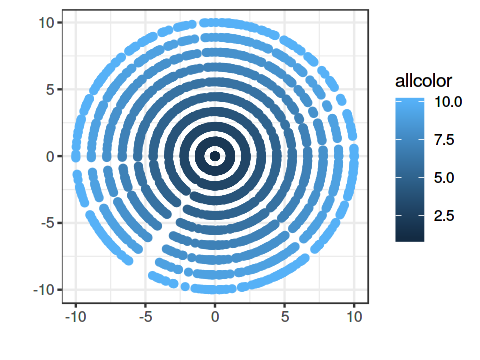

In [6]:
g = ggplot()
options(repr.plot.width = 4, repr.plot.height = 3)
allX = c()
allY = c()
allcolor = c()
for (i in seq(1,numtime)){
    refmat = getParticlePos(mat,i)
    allX = c(allX,refmat[,1])
    allY = c(allY,refmat[,2])
    allcolor = c(allcolor,rep(i,numparticles))
}
g = g + geom_point(aes(x = allX, y = allY, color = allcolor)) 
g = g + theme_bw() + xlab("") + ylab("")
g

In [7]:
homology2_code <- ripserDiag(getParticlePos(mat, 2), 1, 500)
intervals = as.data.frame(homology2_code)
dim0 = intervals[intervals$dimension == 0, ]
dim1 = intervals[intervals$dimension == 1, ]

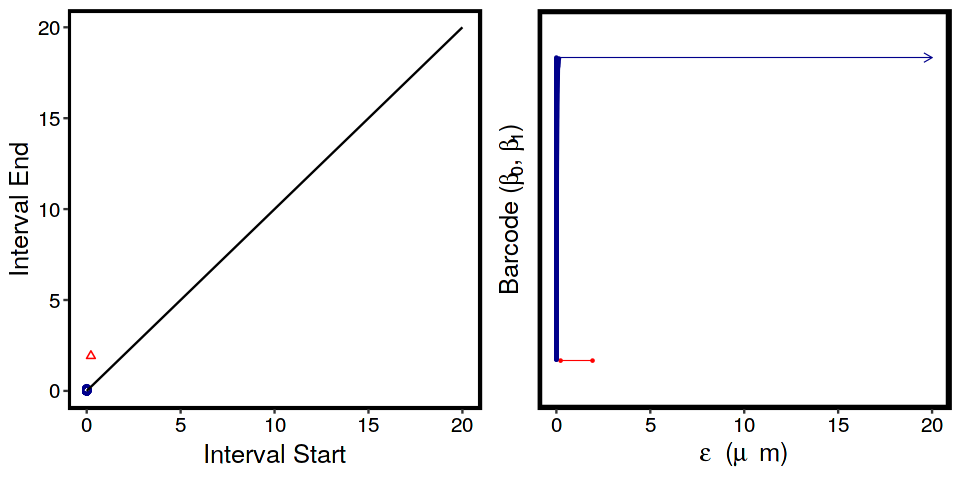

In [8]:
p3 = persistencediag(dim0, dim1, 20)
p4 = combinedbarcode(dim0, dim1, 20)

options(repr.plot.width = 8, repr.plot.height = 4)
grid.newpage()
grid.draw(cbind(ggplotGrob(p3), ggplotGrob(p4), size = "last"))

#### Compile a CROCKER Plot

In [9]:
homology2_code = ripserDiag(getParticlePos(mat,1), 1, 500)
intervals = as.data.frame(homology2_code)
dim0 = intervals[intervals$dimension==0,]
dim1 = intervals[intervals$dimension==1,]
dim(dim0)

[1] 0 3

In [56]:
q = c()
deltaepsilon = 0.01
maxepsilon = 1.0
for (frame in seq(1,numtime)){
    homology2_code <- ripserDiag(getParticlePos(mat,frame), 1, 20)
    intervals = as.data.frame(homology2_code)
    dim0 = intervals[intervals$dimension==0,]    

    binset = c()
    for (i in seq(0,maxepsilon,deltaepsilon)){
        if (i == 0){
            next
        }
        if (dim(dim0)[1] == 0){
            binset = c(binset,0)
        }
        else{
            log1 = (i-deltaepsilon)<dim0[3] & (i)>dim0[2] 
            cellbin = sum(log1)
            binset = c(binset,cellbin)
        }
    }
    q = rbind(q,binset)
}

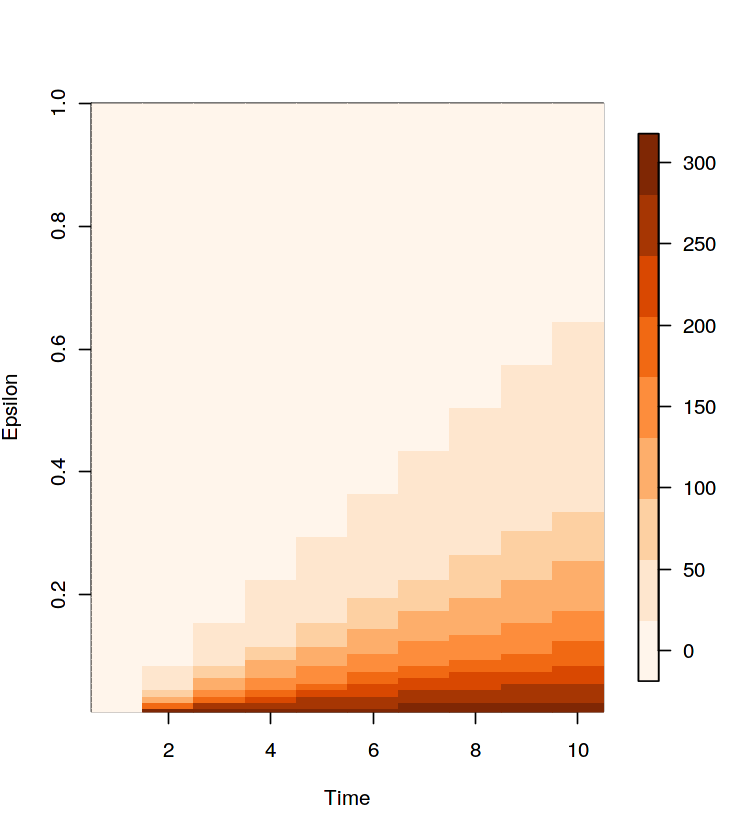

In [63]:
options(repr.plot.width = 6.2, repr.plot.height = 7)
pal3 = brewer.pal(9,"Oranges")

image.plot(1:nrow(m), 1:ncol(q)*deltaepsilon, q, col = pal3, axes = TRUE,xlab="Time",ylab="Epsilon",ylim=c(deltaepsilon,maxepsilon))


In [71]:
q = c()
gradation = 0.01
for (frame in seq(1,numtime)){
    homology2_code <- ripserDiag(getParticlePos(mat,frame), 1, 20)
    intervals = as.data.frame(homology2_code)
    dim1 = intervals[intervals$dimension==1,]
    

    binset = c()
    for (i in seq(0,20,gradation)){
        if (dim(dim1)[1] == 0){
            binset = c(binset,0)
        }
        else{
            log1 = (i-gradation)<dim1[3] & (i)>dim1[2] 
            cellbin = sum(log1)
            binset = c(binset,cellbin)
        }
    }
    q = rbind(q,binset)
}

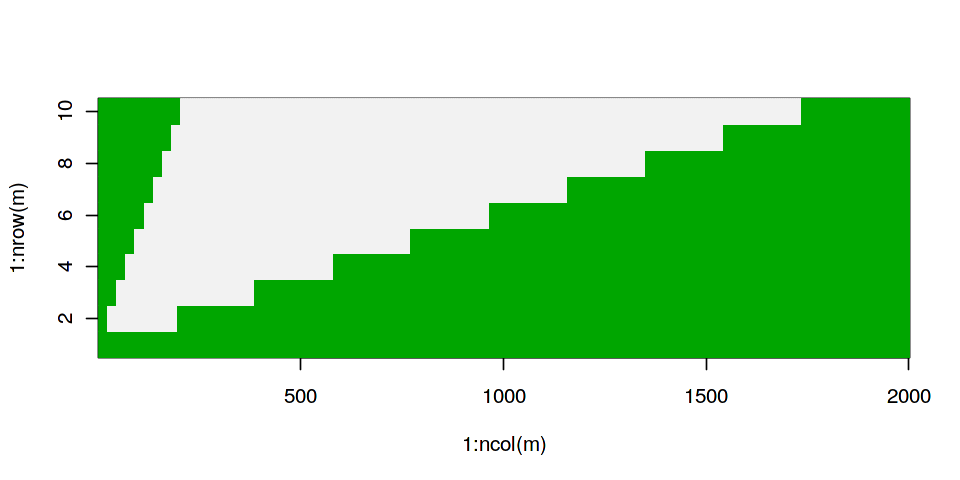

In [72]:
options(repr.plot.width = 8, repr.plot.height = 4)
m = q
image(1:ncol(m), 1:nrow(m), t(m), col = terrain.colors(200), axes = TRUE)

## TO DO LIST (11/29)
- Try Level Plot from Package Lattice
- Put everything into nice, packaged functions
- Try Filled.Contour (https://www.rdocumentation.org/packages/graphics/versions/3.5.1/topics/image)